In [ ]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns


# Replace with your actual folder paths
adata1 = sc.read_h5ad("Preprocess_data/SSTX_counts_adata.h5ad") #no miRNA
adata2 = sc.read_h5ad("Preprocess_data/SSTX_counts_adata_noDASH_miRNA.h5ad") # miRNA(+)


/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


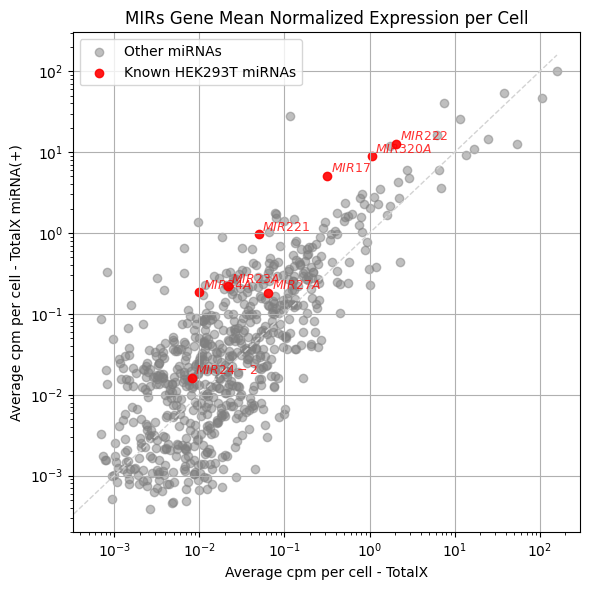

In [ ]:
sc.pp.normalize_total(adata1, target_sum=1e6)
sc.pp.normalize_total(adata2, target_sum=1e6)

# Subset MIR genes to remove HG
mir_adata1 = adata1[:, adata1.var['GeneName'].str.contains(r'^MIR(?!.*HG$)', na=False)].copy()
mir_adata2 = adata2[:, adata2.var['GeneName'].str.contains(r'^MIR(?!.*HG$)', na=False)].copy()

# Optional sanity check: make sure the genes are aligned
assert np.array_equal(mir_adata1.var['GeneName'].values, mir_adata2.var['GeneName'].values), "Gene mismatch!"

# Compute mean normalized counts per gene (per cell)
mir1_mean = np.array(mir_adata1.X.mean(axis=0)).flatten()
mir2_mean = np.array(mir_adata2.X.mean(axis=0)).flatten()

# Create dataframe with mean counts per gene
mir_df = pd.DataFrame({
    'MeanNorm1': mir1_mean,
    'MeanNorm2': mir2_mean
}, index=mir_adata1.var['GeneName'])

# List of miRNAs to highlight (must match the index format)
highlight_mirnas = ["MIR34A", "MIR23A","MIR320A", "MIR27A", "MIR24-2", "MIR17", "MIR222", "MIR221"]
# Create mask for highlighted points
highlight_mask = mir_df.index.isin(highlight_mirnas)

# Plot all points (gray)
plt.figure(figsize=(6, 6))
plt.scatter(mir_df.loc[~highlight_mask, 'MeanNorm1'],
            mir_df.loc[~highlight_mask, 'MeanNorm2'],
            alpha=0.5, color='gray', label='Other miRNAs')

# Plot highlighted miRNAs in red
plt.scatter(mir_df.loc[highlight_mask, 'MeanNorm1'],
            mir_df.loc[highlight_mask, 'MeanNorm2'],
            color='red', alpha=0.9, label='Known HEK293T miRNAs')

# Add y = x diagonal line
min_val = min(mir_df['MeanNorm1'].min(), mir_df['MeanNorm2'].min())
max_val = max(mir_df['MeanNorm1'].max(), mir_df['MeanNorm2'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='lightgray', linestyle='--', linewidth=1)

# Add gene labels for highlighted miRNAs
for gene in mir_df.index[highlight_mask]:
    x = mir_df.loc[gene, 'MeanNorm1']
    y = mir_df.loc[gene, 'MeanNorm2']
    plt.text(x * 1.1, y * 1.1, fr"$\it{{{gene}}}$", fontsize=9, color='red', alpha=0.8)

plt.xlabel('Average cpm per cell - TotalX')
plt.ylabel('Average cpm per cell - TotalX miRNA(+)')
plt.title('MIRs Gene Mean Normalized Expression per Cell')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

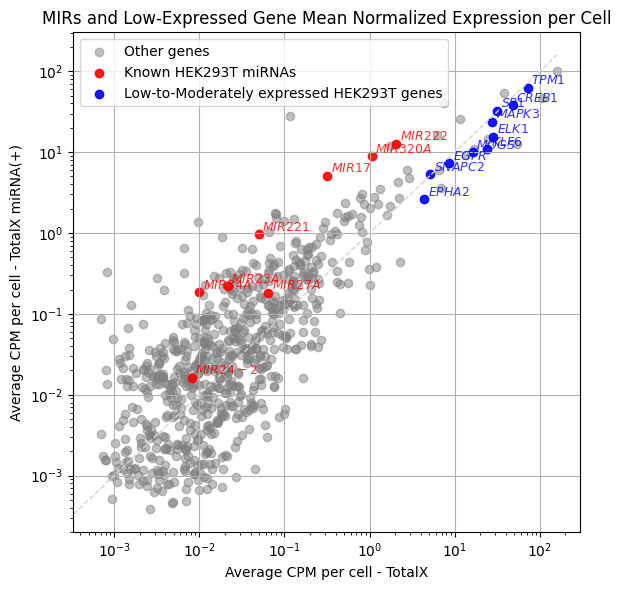

In [3]:
# Define target genes
highlight_mirnas = ["MIR34A", "MIR23A", "MIR320A", "MIR27A", "MIR24-2", "MIR17", "MIR222", "MIR221"]
low_expr_genes = [ "MOGS", "SNAPC2", "SP1", "CREB1","EGFR", "EPHA2", "MAPK3", "TPM1", "ELK1", "KLF6"]

# Create a combined mask for MIR genes and low expressed genes
mir_mask = adata1.var['GeneName'].str.contains(r'^MIR(?!.*HG$)', na=False)
low_expr_mask = adata1.var['GeneName'].isin(low_expr_genes)
combined_mask = mir_mask | low_expr_mask

# Subset adata1 and adata2 to include both miRNAs and the low-expressed genes
combined_adata1 = adata1[:, combined_mask].copy()
combined_adata2 = adata2[:, combined_mask].copy()

# Optional sanity check: make sure the genes are aligned
assert np.array_equal(combined_adata1.var['GeneName'].values, combined_adata2.var['GeneName'].values), "Gene mismatch!"

# Compute mean normalized counts per gene (per cell)
mir1_mean = np.ravel(combined_adata1.X.mean(axis=0))
mir2_mean = np.ravel(combined_adata2.X.mean(axis=0))

# Create DataFrame with mean counts per gene
mir_df = pd.DataFrame({
    'MeanNorm1': mir1_mean,
    'MeanNorm2': mir2_mean
}, index=combined_adata1.var['GeneName'])

# Create masks for plotting
highlight_mask = mir_df.index.isin(highlight_mirnas)
low_expr_mask = mir_df.index.isin(low_expr_genes)

# Plot
plt.figure(figsize=(6, 6))

# Plot other genes in gray
plt.scatter(mir_df.loc[~highlight_mask & ~low_expr_mask, 'MeanNorm1'],
            mir_df.loc[~highlight_mask & ~low_expr_mask, 'MeanNorm2'],
            alpha=0.5, color='gray', label='Other genes')

# Plot highlighted miRNAs in red
plt.scatter(mir_df.loc[highlight_mask, 'MeanNorm1'],
            mir_df.loc[highlight_mask, 'MeanNorm2'],
            color='red', alpha=0.9, label='Known HEK293T miRNAs')

# Plot low-expressed protein-coding genes in blue
plt.scatter(mir_df.loc[low_expr_mask, 'MeanNorm1'],
            mir_df.loc[low_expr_mask, 'MeanNorm2'],
            color='blue', alpha=0.9, label='Low-to-Moderately expressed HEK293T genes')

# Add y = x diagonal line
min_val = min(mir_df['MeanNorm1'].min(), mir_df['MeanNorm2'].min())
max_val = max(mir_df['MeanNorm1'].max(), mir_df['MeanNorm2'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='lightgray', linestyle='--', linewidth=1)

# Add gene labels for highlighted miRNAs (red)
for gene in mir_df.index[highlight_mask]:
    x = mir_df.loc[gene, 'MeanNorm1']
    y = mir_df.loc[gene, 'MeanNorm2']
    plt.text(x * 1.1, y * 1.1, fr"$\it{{{gene}}}$", fontsize=9, color='red', alpha=0.8)

# Add gene labels for low-expressed genes (blue)
for gene in mir_df.index[low_expr_mask]:
    x = mir_df.loc[gene, 'MeanNorm1']
    y = mir_df.loc[gene, 'MeanNorm2']
    plt.text(x * 1.1, y * 1.1, fr"$\it{{{gene}}}$", fontsize=9, color='blue', alpha=0.8)

plt.xlabel('Average CPM per cell - TotalX')
plt.ylabel('Average CPM per cell - TotalX miRNA(+)')
plt.title('MIRs and Low-Expressed Gene Mean Normalized Expression per Cell')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


   Unnamed: 0                    Sample ID  Number of Reads  \
0           0          10X-HEK293T_trimmed        669880632   
1           1         SSTX-HEK293T_trimmed       1285094223   
2           2  SSTX-HEK293T-2XDASH_trimmed       1995361419   
3           3  SSTX-HEK293T-noDASH_trimmed       2435415331   

   Valid Barcodes (%)  Valid UMIs (%)  Sequencing Saturation (%)  \
0                92.8            99.9                       12.6   
1                97.9            99.9                       50.9   
2                97.2            99.9                       18.9   
3                97.2            99.9                       25.7   

   Reads Mapped to Genome (%)  Reads Mapped Confidently to Genome (%)  \
0                        96.9                                    89.4   
1                        97.3                                    88.2   
2                        66.8                                    40.7   
3                        70.1                      

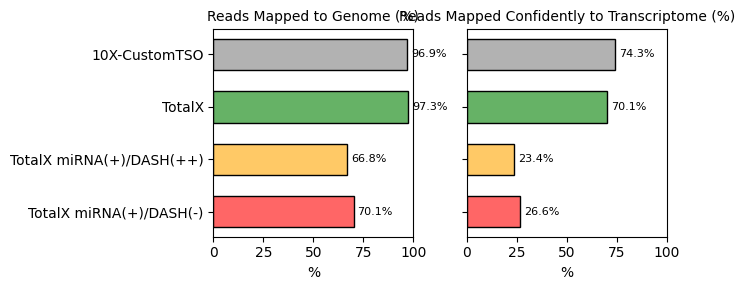

In [ ]:

# Load the CSV file into a DataFrame
file_path = "F1.method_comparison/sequencing_and_mapping_with_labels.csv"  # Update this path if the file is stored elsewhere
data = pd.read_csv(file_path)

# Add simplified labels as a new column
data["Label"] = ["10X-CustomTSO", "TotalX", "TotalX miRNA(+)/DASH(++)", "TotalX miRNA(+)/DASH(-)"]

print(data)

# Define the metrics and labels
metrics = [
    "Reads Mapped to Genome (%)",
    "Reads Mapped Confidently to Transcriptome (%)",
]
labels = data["Label"]

# Extract the filtered data for the metrics
data_metrics = [data[metric].iloc[::-1] for metric in metrics]
labels = data["Label"].iloc[::-1]

# Define bar positions
y = np.arange(len(labels))  # Positions for each group
bar_height = 0.6  # Height of each bar

# Define colors for the remaining samples
sample_colors = [to_rgba(color, alpha=0.6) for color in ["red", "orange",  "green", "gray"]]


# Create the figure and axes for a 1x4 grid
fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 4 columns of subplots

# Plot each metric in a subplot
for idx, (ax, metric_data, metric_name) in enumerate(zip(axs, data_metrics, metrics)):
    for i, (pos, value) in enumerate(zip(y, metric_data)):
        ax.barh(pos, value, bar_height, color=sample_colors[i], edgecolor="black", label=labels.iloc[i])
        # Add text to the bars
        ax.text(value + 2, pos, f"{value:.1f}%", va="center", ha="left", fontsize=8)
    ax.set_yticks(y)
    if idx == 0:
        ax.set_yticklabels(labels)  # Show labels only on the first subplot
    else:
        ax.set_yticklabels([])  # Hide y-axis labels for other subplots
    ax.set_title(metric_name, fontsize=10)
    ax.set_xlabel("%")
    ax.set_xlim(0, 100)
    #if idx == 0:  # Add legend only for the first subplot
    #    ax.legend(title="Samples", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout and save the figure
plt.tight_layout()
plt.show()

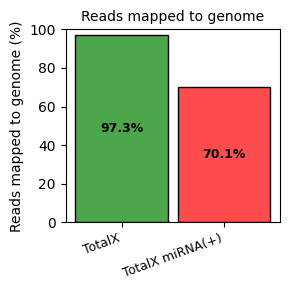

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
filtered_data = data[
    data["Label"].isin(["TotalX", "TotalX miRNA(+)/DASH(-)"])
].copy()

# Reverse order for plotting
filtered_data = filtered_data.iloc[::-1]
# Filter your data for only the two samples and the specific metric
plot_metric = "Reads Mapped to Genome (%)"
samples_of_interest = ["TotalX", "TotalX miRNA(+)/DASH(-)"]
labels_display = ["TotalX", "TotalX miRNA(+)"]
filtered_plot_data = filtered_data[filtered_data["Label"].isin(samples_of_interest)]
plot_values = filtered_plot_data.set_index("Label").loc[samples_of_interest, plot_metric].values
labels = samples_of_interest

# Define colors: SSTX green, miRNA(+) red
sample_colors = [to_rgba("green", alpha=0.7), to_rgba("red", alpha=0.7)]

# Create the vertical bar plot
fig, ax = plt.subplots(figsize=(3, 3))

bar_positions = np.arange(len(labels))
bar_width = 0.9

bars = ax.bar(bar_positions, plot_values, bar_width, color=sample_colors, edgecolor="black")

# Add text labels above bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{height:.1f}%", 
        ha='center', va='center', fontsize=9, color='black', fontweight='bold')

# Customize plot
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels_display, rotation=20, ha='right', fontsize=9)
ax.set_ylabel("Reads mapped to genome (%)", fontsize=10)
ax.set_ylim(0, 100)
ax.set_title("Reads mapped to genome", fontsize=10)

plt.tight_layout()
plt.show()


In [6]:
import pysam
print(pysam.__version__)

0.22.1


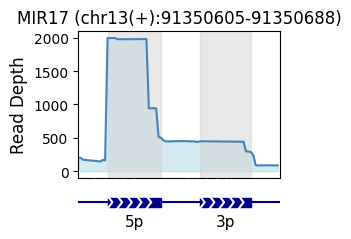

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pysam
from matplotlib.gridspec import GridSpec

# Constants
chromosome = "chr13"
start, end = 91350605, 91350688
exons = [(91350617, 91350639), (91350655, 91350676)]
gene_name = "MIR17"
strand = '+'

# Load coverage from HEK293T BAM
bam_file = "SSTX-HEK293T-noDASH_trimmed/outs/possorted_genome_bam.bam"
bam = pysam.AlignmentFile(bam_file, "rb")
coverage = [0] * (end - start)

for read in bam.fetch(chromosome, start, end):
    for i in range(max(read.reference_start, start), min(read.reference_end, end)):
        coverage[i - start] += 1
bam.close()

# Create plot
fig = plt.figure(figsize=(3, 2.5))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# Coverage track
ax1 = fig.add_subplot(gs[0])
adjusted_coverage = np.array(coverage)
adjusted_coverage[adjusted_coverage < 0] = 0

ax1.plot(range(start, end), adjusted_coverage, color="steelblue", linewidth=1.5)
ax1.fill_between(range(start, end), adjusted_coverage, color="lightblue", alpha=0.5)

ax1.set_title(f"{gene_name} ({chromosome}(+):{start}-{end})", fontsize=12)
ax1.set_ylabel("Read Depth", fontsize=12)
ax1.set_xlim(start, end)
ax1.tick_params(labelbottom=False, bottom=False)
ax1.grid(False)

# Exon highlights
for s, e in exons:
    ax1.axvspan(s, e, color="lightgray", alpha=0.5)

# Gene model
ax2 = fig.add_subplot(gs[1], sharex=ax1)
track_y = 0.9
track_height = 0.06
arrow_spacing = 4
chevron_size = 7

# Transcript body
ax2.plot([start, end], [track_y + track_height / 2] * 2,
         color='darkblue', linewidth=track_height * 25, solid_capstyle='butt', zorder=1)

# Exons
for exon_start, exon_end in exons:
    ax2.add_patch(patches.Rectangle(
        (exon_start, track_y), exon_end - exon_start, track_height,
        edgecolor='darkblue', facecolor='darkblue', zorder=2
    ))

# Strand arrows
arrow_positions = []
for exon_start, exon_end in exons:
    exon_arrows = np.arange(exon_start + 2, exon_end - 2, arrow_spacing)
    arrow_positions.extend(exon_arrows)

for x in arrow_positions:
    if strand == '+':
        ax2.plot([x - chevron_size, x, x - chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)
    else:
        ax2.plot([x + chevron_size, x, x + chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)

# Gene label and 5p/3p
gene_label_y = track_y - 0.3
#ax2.text((start + end) / 2, gene_label_y, gene_name,
#         ha='center', va='center', fontsize=11, style='italic')
ax2.axis('off')

label_y = track_y - 0.1
ax2.text(exons[0][0] + (exons[0][1] - exons[0][0]) / 2,
         label_y, "5p", ha='center', va='center', fontsize=11)
ax2.text(exons[-1][0] + (exons[-1][1] - exons[-1][0]) / 2,
         label_y, "3p", ha='center', va='center', fontsize=11)

# Export and show
plt.tight_layout()
plt.show()


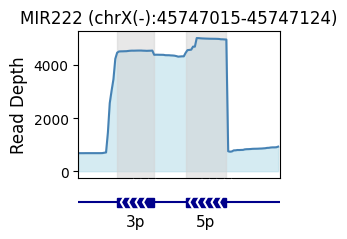

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pysam
from matplotlib.gridspec import GridSpec

# ==== Define parameters for MIR222 ====
gene_name = "MIR222"
chromosome = "chrX"
start, end = 45747015, 45747124
exons = [(45747036, 45747056), (45747073, 45747095)]  # 5p and 3p
strand = '-'  # Important for arrow direction

# ==== BAM file path ====
bam_file = "SSTX-HEK293T-noDASH_trimmed/outs/possorted_genome_bam.bam"

# ==== Load coverage ====
bam = pysam.AlignmentFile(bam_file, "rb")
coverage = [0] * (end - start)
for read in bam.fetch(chromosome, start, end):
    for i in range(max(read.reference_start, start), min(read.reference_end, end)):
        coverage[i - start] += 1
bam.close()

# ==== Create plot ====
fig = plt.figure(figsize=(3, 2.5))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# --- Plot 1: Coverage ---
ax1 = fig.add_subplot(gs[0])
adjusted_coverage = np.array(coverage)
adjusted_coverage[adjusted_coverage < 0] = 0

ax1.plot(range(start, end), adjusted_coverage, color="steelblue", linewidth=1.5)
ax1.fill_between(range(start, end), adjusted_coverage, color="lightblue", alpha=0.5)

ax1.set_title(f"{gene_name} ({chromosome}({strand}):{start}-{end})", fontsize=12)
ax1.set_ylabel("Read Depth", fontsize=12)
ax1.set_xlim(start, end)
ax1.tick_params(labelbottom=False, bottom=False)
ax1.grid(False)

# --- Highlight exons ---
for s, e in exons:
    ax1.axvspan(s, e, color="lightgray", alpha=0.5)

# --- Plot 2: Gene model ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
track_y = 0.9
track_height = 0.06
arrow_spacing = 4
chevron_size = 7

# Transcript body line
ax2.plot([start, end], [track_y + track_height / 2] * 2,
         color='darkblue', linewidth=track_height * 25, solid_capstyle='butt', zorder=1)

# Draw exons
for exon_start, exon_end in exons:
    ax2.add_patch(patches.Rectangle(
        (exon_start, track_y), exon_end - exon_start, track_height,
        edgecolor='darkblue', facecolor='darkblue', zorder=2
    ))

# Draw strand arrows inside exons
arrow_positions = []
for exon_start, exon_end in exons:
    exon_arrows = np.arange(exon_start + 2, exon_end - 2, arrow_spacing)
    arrow_positions.extend(exon_arrows)

for x in arrow_positions:
    if strand == '+':
        ax2.plot([x - chevron_size, x, x - chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)
    else:
        ax2.plot([x + chevron_size, x, x + chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)

# --- 5p / 3p labels ---
label_y = track_y - 0.1
ax2.text(exons[0][0] + (exons[0][1] - exons[0][0]) / 2,
         label_y, "3p", ha='center', va='center', fontsize=11)
ax2.text(exons[-1][0] + (exons[-1][1] - exons[-1][0]) / 2,
         label_y, "5p", ha='center', va='center', fontsize=11)

ax2.axis('off')

# ==== Export ====
plt.tight_layout()
plt.show()


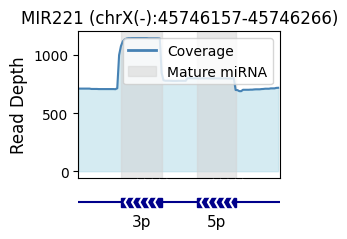

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pysam
from matplotlib.gridspec import GridSpec

# ==== Parameters for MIR221 ====
gene_name = "MIR221"
chromosome = "chrX"
start, end = 45746157, 45746266
exons = [(45746180, 45746202), (45746221, 45746242)]  # 5p, 3p (use order for visual placement)
strand = '-'  # Important for arrow direction

# ==== BAM file ====
bam_file = "SSTX-HEK293T-noDASH_trimmed/outs/possorted_genome_bam.bam"

# ==== Compute coverage ====
bam = pysam.AlignmentFile(bam_file, "rb")
coverage = [0] * (end - start)
for read in bam.fetch(chromosome, start, end):
    for i in range(max(read.reference_start, start), min(read.reference_end, end)):
        coverage[i - start] += 1
bam.close()

# ==== Create plot ====
fig = plt.figure(figsize=(3, 2.5))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.0)

# --- Plot 1: Coverage ---
ax1 = fig.add_subplot(gs[0])
adjusted_coverage = np.array(coverage)
adjusted_coverage[adjusted_coverage < 0] = 0

ax1.plot(range(start, end), adjusted_coverage, color="steelblue", linewidth=1.5)
ax1.fill_between(range(start, end), adjusted_coverage, color="lightblue", alpha=0.5)

ax1.set_title(f"{gene_name} ({chromosome}({strand}):{start}-{end})", fontsize=12)
ax1.set_ylabel("Read Depth", fontsize=12)
ax1.set_xlim(start, end)
ax1.tick_params(labelbottom=False, bottom=False)
# Add legend handles
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='steelblue', lw=2, label='Coverage'),
    Patch(facecolor='lightgray', edgecolor='lightgray', alpha=0.5, label='Mature miRNA')
]

ax1.legend(handles=legend_elements, fontsize=10, loc='upper right', frameon=True)

ax1.grid(False)

# --- Exon highlights ---
for s, e in exons:
    ax1.axvspan(s, e, color="lightgray", alpha=0.5)

# --- Plot 2: Gene model ---
ax2 = fig.add_subplot(gs[1], sharex=ax1)
track_y = 0.9
track_height = 0.06
arrow_spacing = 4
chevron_size = 7

# Transcript line
ax2.plot([start, end], [track_y + track_height / 2] * 2,
         color='darkblue', linewidth=track_height * 25, solid_capstyle='butt', zorder=1)

# Exon boxes
for exon_start, exon_end in exons:
    ax2.add_patch(patches.Rectangle(
        (exon_start, track_y), exon_end - exon_start, track_height,
        edgecolor='darkblue', facecolor='darkblue', zorder=2
    ))

# Strand arrows
arrow_positions = []
for exon_start, exon_end in exons:
    exon_arrows = np.arange(exon_start + 2, exon_end - 2, arrow_spacing)
    arrow_positions.extend(exon_arrows)

for x in arrow_positions:
    if strand == '+':
        ax2.plot([x - chevron_size, x, x - chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)
    else:
        ax2.plot([x + chevron_size, x, x + chevron_size],
                 [track_y + track_height / 2 - 0.15,
                  track_y + track_height / 2,
                  track_y + track_height / 2 + 0.15],
                 color='white', linewidth=1.5, zorder=3)

# --- 5p / 3p labels ---
label_y = track_y - 0.1
ax2.text(exons[0][0] + (exons[0][1] - exons[0][0]) / 2,
         label_y, "3p", ha='center', va='center', fontsize=11)
ax2.text(exons[-1][0] + (exons[-1][1] - exons[-1][0]) / 2,
         label_y, "5p", ha='center', va='center', fontsize=11)

ax2.axis('off')

# ==== Save and show ====
plt.tight_layout()
plt.show()
